# Introduction
The following uses the Titanic dataset obtained via Kaggle https://www.kaggle.com/c/titanic/overview/evaluation . I visualize the relationships of the variables with survival of each passenger, attempt to generate additional useful features and use two ML models to predict survival (Namely Random Forest and XGBoost, as I have seen it perform the best when it comes to classification). Both were subjected to hyperparameter tuning before settling on the final model. The metric used is accuracy and cross-fold validation is implemented to get a better estimate of the model's performance on unseen data

# Table of Contents
 _[Data Cleaning](#DataCleaning)_
 
 _[Feature Engineering, Visualization & EDA](#FE)_
 
 _[Modelling](#Mod)_
 
 &nbsp;&nbsp;&nbsp;&nbsp;_[Model 1: Random Forest Classifier](#RF)_
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_[Hyperparameter tuning using Grid Search CV](#RFGSCV)_
 
 &nbsp;&nbsp;&nbsp;&nbsp;_[Model 2: XGBoost Classifier](#XGB)_
 
 &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;_[Hyperparameter tuning](#XGBGSCV)_
 
 &nbsp;&nbsp;&nbsp;&nbsp;_[Plotting Confusion Matrix for both models](#CF)_
 
 &nbsp;&nbsp;&nbsp;&nbsp;_[Visualizing Feature Importance for the Random Forest Model](#FI)_
 
 _[Predicting using the final model for submission](#Predict)_

In [1]:
import pandas as pd # data processing
import sklearn as sklearn #machine learning library
import numpy as np
import warnings
warnings.filterwarnings('ignore')

#Importing matplotlib for graphing 
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
%matplotlib inline

In [2]:
Train_full=pd.read_csv('../Downloads/Titanic/train.csv',index_col='PassengerId')
Test_full=pd.read_csv('../Downloads/Titanic/test.csv',index_col='PassengerId')
Train_full.shape

(891, 11)

<a id='DataCleaning'></a>
# Data Cleaning

In [3]:
#Drop rows where value for survived is missing
Train_full=Train_full.dropna(subset=['Survived'],axis=0)

In [4]:
# Create a list of the datasets so that we can do the same process for training as well as test datasets
Datasets=[Train_full,Test_full]

### Dealing with missing values

In [5]:
#Counting the number of missing values by column
print("Testing set null values\n",Test_full.isnull().sum())
print("\nTraining set null values\n",Train_full.isnull().sum())

Testing set null values
 Pclass        0
Name          0
Sex           0
Age          86
SibSp         0
Parch         0
Ticket        0
Fare          1
Cabin       327
Embarked      0
dtype: int64

Training set null values
 Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64


### Filling in missing values for 'Fare' and 'Embarked'


In [6]:
#Fill in missing values using Pandas fillna for both training and test data
for Dataset in Datasets:
    Dataset['Embarked'].fillna(Dataset['Embarked'].mode()[0],inplace=True)
    Dataset['Fare'].fillna(Dataset['Fare'].median(),inplace=True) #Skewed distribution, hence, median


<a id='FE'></a>
# Feature Engineering, Visualization, EDA
Closely examining each variable, visualizing patterns in survival, creating new variables

#### _Variables:_

&nbsp;&nbsp;&nbsp;&nbsp;_[Sex](#Sex)_

&nbsp;&nbsp;&nbsp;&nbsp;_[Passenger Class](#Pclass)_

&nbsp;&nbsp;&nbsp;&nbsp;_[Embarked](#Emb)_

&nbsp;&nbsp;&nbsp;&nbsp;_[Fare](#Fare)_

&nbsp;&nbsp;&nbsp;&nbsp;_[Age](#Age)_

&nbsp;&nbsp;&nbsp;&nbsp;_[Cabin](#Cabin)_

&nbsp;&nbsp;&nbsp;&nbsp;_[SibSp (Siblings and Spouse), Parch (Parents and Children)](#SibSpParch)_

&nbsp;&nbsp;&nbsp;&nbsp;_[Name](#Name)_



_[Correlation of each variable with survival](#Corr)_

_[Dropping unnecessary variables](#Drop)_

_[Train test split](#Train)_


<a id='Sex'></a>
## 'Sex' variable
### Recoding to binary

In [7]:
#Change Sex variable to 1 for female, 0 for male
for Dataset in Datasets:
    Dataset['Sex']=Dataset['Sex'].replace('female',1)
    Dataset['Sex']=Dataset['Sex'].replace('male',0)

### Visualizing survival across sexes

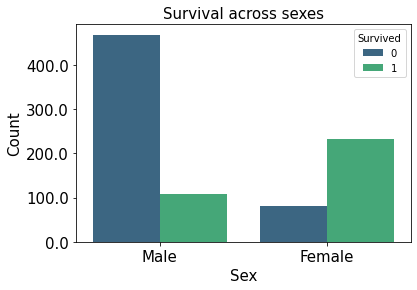

In [8]:
ax=sns.countplot(x=Train_full['Sex'],data=Train_full, hue='Survived', palette='viridis')
ax.set_title('Survival across sexes', fontsize=15)
ax.set_xlabel("Sex",fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.set_yticklabels(ax.get_yticks(), size = 15)
ax.set_xticklabels(['Male','Female'], size = 15)
ax.legend(fontsize=10, title="Survived")

Sex seems to be the clearest indicator of survival

### 'Women & Upper class variable'
Women tend to have survived more. Perhaps the rate of survival is more among upper class women who might have gotten priority during evacuation

Text(0.5, 1.0, 'Survival across women of different status')

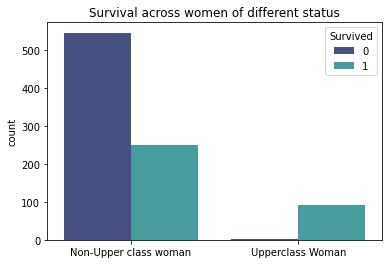

In [9]:
Train_full['Woman&UpperClass']=0
Train_full.loc[(Train_full['Sex']==1) & (Train_full['Pclass']==1),'Woman&UpperClass']=1
Test_full['Woman&UpperClass']=0
Test_full.loc[(Test_full['Sex']==1) & (Test_full['Pclass']==1),'Woman&UpperClass']=1

ax=sns.countplot(x=Train_full['Woman&UpperClass'],data=Train_full,hue='Survived',palette='mako')
ax.set_xticklabels(['Non-Upper class woman','Upperclass Woman'])
ax.set_xlabel("")
ax.set_title("Survival across women of different status")

<a id='Pclass'></a>
## 'Pclass' variable
### Visualizing survival across different socio-economic classes

<AxesSubplot:xlabel='Pclass', ylabel='count'>

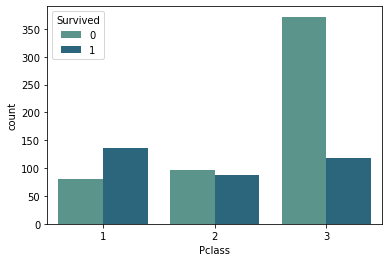

In [10]:
sns.countplot(x=Train_full['Pclass'],hue='Survived',data=Train_full,palette='crest')

<a id='Emb'></a>
## 'Embarked' variable
### Visualizing survival against port of embarkment

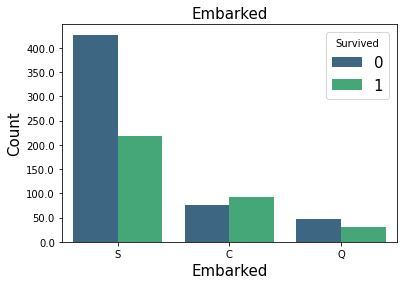

In [11]:
ax=sns.countplot(x=Train_full['Embarked'],data=Train_full, hue='Survived', palette='viridis')
ax.set_title('Embarked', fontsize=15)
ax.set_xlabel('Embarked',fontsize=15)
ax.set_ylabel("Count", fontsize=15)
ax.set_yticklabels(ax.get_yticks(), size = 10)

ax.legend(fontsize=15, title="Survived")
plt.show()

### Create dummies for the Embarked column

In [12]:
Train_full=pd.get_dummies(Train_full, columns=['Embarked'],prefix=['Embarked'])
Test_full=pd.get_dummies(Test_full, columns=['Embarked'],prefix=['Embarked'])

<a id='Fare'></a>
## 'Fare' variable
### Distribution of Fare rates by survival

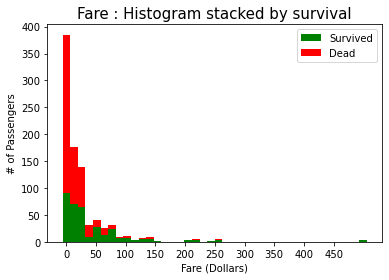

In [13]:
plt.hist(x = [Train_full[Train_full['Survived']==1]['Fare'], Train_full[Train_full['Survived']==0]['Fare']], 
         stacked=True, color = ['g','r'],label = ['Survived','Dead'],bins=40,align='left')
plt.title('Fare : Histogram stacked by survival', fontsize=15)
plt.xlabel('Fare (Dollars)',fontsize=10)
plt.ylabel('# of Passengers',fontsize=10)
plt.legend()
plt.xticks(range(0,500,50))
plt.show()

### Creating Fare <=50 variable
From the stacked histogram, it seems that a higher proportion of those who bought expensive tickets survived

In [14]:
#Fare=50 as a cutting point
Train_full['Fare_less50']=0
Train_full.loc[Train_full['Fare']<=50, 'Fare_less50'] = 1

Test_full['Fare_less50']=0
Test_full.loc[Test_full['Fare']<=50, 'Fare_less50'] = 1

<a id='Age'></a>
## 'Age' variable

### Can missing values itself be an indicator?
It is likely that data is missing for passengers that are dead compared to those alive. Along the way, I will be creating 'feature missing' dummy variables e.g. An 'Age Missing' column. This will also be done for 'Cabin' Variable later on

In [15]:
#Creating an age missing column

Train_full['Age Missing']=0
Train_full.loc[Train_full['Age'].isna(), 'Age Missing'] = 1

Test_full['Age Missing']=0
Test_full.loc[Test_full['Age'].isna(), 'Age Missing'] = 1

# Filling in missing values for Age
Train_full['Age'].fillna(Train_full['Age'].median(),inplace=True) #Both median and mean are close to each other
Test_full['Age'].fillna(Test_full['Age'].median(),inplace=True) #Both median and mean are close to each other

### Visualizing distribution of age against survival

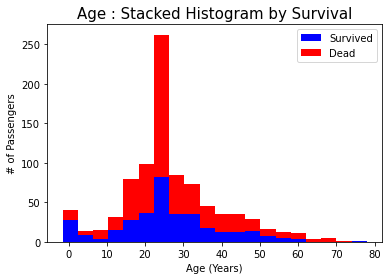

In [16]:
# plt.rc('figure',figsize = (15,5))
plt.hist(x = [Train_full[Train_full['Survived']==1]['Age'], Train_full[Train_full['Survived']==0]['Age']], 
         stacked=True, color = ['b','r'],label = ['Survived','Dead'],bins=20,align='left')
plt.title('Age : Stacked Histogram by Survival', fontsize=15)
plt.xlabel('Age (Years)')
plt.ylabel('# of Passengers')
#plt.xticks(range(0,80,10))
plt.legend()
plt.show()

No particular pattern is seen in how the distribution of age affects survival. It seems that a higher proportion of children (esspecially those under 5) seem to survive.
### Visualizing suvival across 'Age Missing'

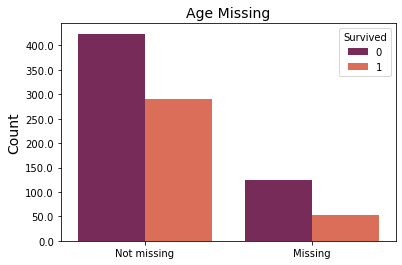

In [17]:
ax=sns.countplot(x=Train_full['Age Missing'],data=Train_full,hue='Survived',palette='rocket')
ax.set_title('Age Missing', fontsize=14)
ax.set_xlabel("")
ax.set_ylabel("Count", fontsize=14)
ax.set_yticklabels(ax.get_yticks(), size = 10)
ax.set_xticklabels(['Not missing','Missing'], size = 10)
ax.legend(fontsize=10, title="Survived")

No distinct patterns seen

### Creating an 'IsChild' dummy variable with cutoff of 16 years
The Titanic followed a 'Women and Children first' rule during evacuation, which led to a larger proportion of them surviving. In the Age histogram above, the proportion of childern (towards the left of 20 yr mark) surviving is  much higher

Text(0.5, 1.0, 'Survival across children')

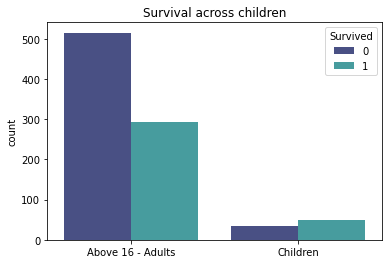

In [18]:
Train_full['IsChild']=0
Train_full.loc[Train_full['Age']<16,'IsChild']=1
Test_full['IsChild']=0
Test_full.loc[Test_full['Age']<16,'IsChild']=1 #The number 16 is an arbitrary cutoff

ax=sns.countplot(x=Train_full['IsChild'],data=Train_full,hue='Survived',palette='mako')
ax.set_xticklabels(['Above 16 - Adults','Children'])
ax.set_xlabel("")
ax.set_title("Survival across children")

Children seem to have a slightly higher survival rate

<a id='Cabin'></a>
## 'Cabin' variable
### Create Cabin_Missing variable
Like Age, the missing data itself could indicate death or survival

In [19]:
Train_full['Cabin Missing']=0
Train_full.loc[Train_full['Cabin'].isna(), 'Cabin Missing'] = 1
Test_full['Cabin Missing']=0
Test_full.loc[Test_full['Cabin'].isna(), 'Cabin Missing'] = 1

Train_full['Cabin'].fillna("Missing",inplace=True)
Test_full['Cabin'].fillna("Missing",inplace=True)

### Visualizing survival based on missing cabin data

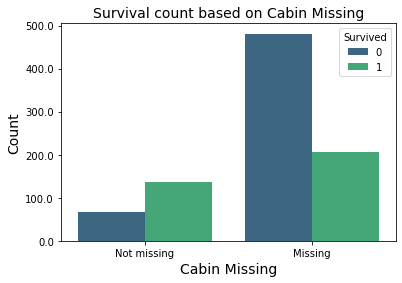

In [20]:
ax=sns.countplot(x=Train_full['Cabin Missing'],data=Train_full, hue='Survived', palette='viridis')
ax.set_title('Survival count based on Cabin Missing', fontsize=14)
ax.set_xlabel("Cabin Missing",fontsize=14)
ax.set_ylabel("Count", fontsize=14)
ax.set_yticklabels(ax.get_yticks(), size = 10)
ax.set_xticklabels(['Not missing','Missing'], size = 10)
ax.legend(fontsize=10, title="Survived")

### Dummy variable for each cabin letter

In [21]:
Letters=['A','B','C','D','E','F','G']

for letter in Letters:
    Train_full.loc[Train_full['Cabin'].str.contains(letter), 'Cabin']=letter
    Test_full.loc[Test_full['Cabin'].str.contains(letter), 'Cabin']=letter
    Train_full[letter]=Train_full['Cabin'].str.contains(letter)
    Train_full[letter].fillna(False,inplace=True)
    Test_full[letter]=Test_full['Cabin'].str.contains(letter)
    Test_full[letter].fillna(False,inplace=True)

### Visualizing survival across each cabin

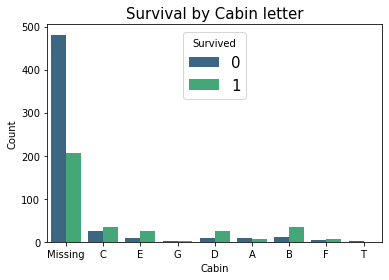

In [22]:
ax=sns.countplot(x=Train_full['Cabin'],data=Train_full, hue='Survived', palette='viridis')
ax.set_title('Survival by Cabin letter', fontsize=15)
ax.get_xlabel
ax.set_ylabel("Count", fontsize=10)
ax.legend(fontsize=15, title="Survived")

It seems there aren't remarkable differences in survival across each cabin. However, a large number of people missing cabin data seem to have dies

<a id='SibSpParch'></a>
## 'SibSp', 'Parch' variables

SibSp=Number of Siblings or Spouse accompanying the passenger

Parch=Number of parents and children accompanying the passenger
### Creating 'Is Alone' variable

In [23]:
Train_full['IsAlone']=0 
Train_full.loc[Train_full['SibSp']+Train_full['Parch']==0, 'IsAlone'] = 1
Test_full['IsAlone']=0 
Test_full.loc[Test_full['SibSp']+Test_full['Parch']==0, 'IsAlone'] = 1

### Visualizing survival based on travelling alone vs accompanied

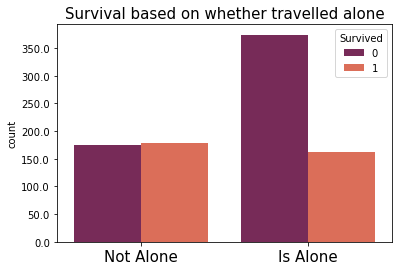

In [24]:
ax=sns.countplot(x=Train_full['IsAlone'],data=Train_full, hue='Survived', palette='rocket')
ax.set_title('Survival based on whether travelled alone', fontsize=15)
ax.set_xlabel("")
# ax.set_ylabel("Count", fontsize=20)
ax.set_yticklabels(ax.get_yticks(), size = 10)
ax.set_xticklabels(['Not Alone','Is Alone'], size = 15)
ax.legend(fontsize=10, title="Survived")

From the plot, it seems that those who were not alone had an approximately 50% chance of survival while being alone rapidly decreased the probability of survival.

### Create Family Size variable

In [25]:
Train_full['FamilySize']=Train_full['SibSp']+Train_full['Parch']
Test_full['FamilySize']=Test_full['SibSp']+Test_full['Parch']

### Visualize survival based on Family size

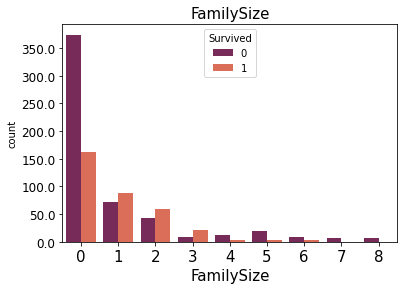

In [26]:
ax=sns.countplot(x=Train_full['FamilySize'],data=Train_full, hue='Survived', palette='rocket')
ax.set_title('FamilySize', fontsize=15)
ax.set_xlabel("FamilySize",fontsize=15)
ax.set_yticklabels(ax.get_yticks(), size = 12)
ax.set_xticklabels(ax.get_xticks(), size = 15)
ax.legend(fontsize=10, title="Survived",title_fontsize=10)


In [27]:
print("Total number of families of each size \n",Train_full['FamilySize'].value_counts())

Total number of families of each size 
 0     537
1     161
2     102
3      29
5      22
4      15
6      12
10      7
7       6
Name: FamilySize, dtype: int64


Being alone (family size 0) is already captured by the 'Is Alone' variable. The differences in survival are very small across family sizes 1-3. It seems those who travelled with larger families may have stayed behind on the ship to help their members, as between family sizes 4-8, there are relatively fewer survivors. Hence we make a variable titled 'Fam_Size>4'

### Create a 'Family Size>=4 variable'

In [28]:
Train_full['Fam_Size>=4']=0 
Train_full.loc[Train_full['SibSp']+Train_full['Parch']>=4, 'Fam_Size>=4'] = 1

Test_full['Fam_Size>=4']=0 
Test_full.loc[Test_full['SibSp']+Test_full['Parch']>=4, 'Fam_Size>=4'] = 1

Text(0.5, 0, '')

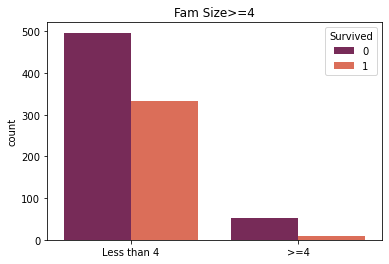

In [29]:
ax=sns.countplot(x=Train_full['Fam_Size>=4'],data=Train_full,hue='Survived',palette='rocket')
ax.set_xticklabels(['Less than 4', ">=4"],fontsize=10)
ax.set_title("Fam Size>=4")
ax.set_xlabel("")

## 'Name' variable
### Survival based on titles found in names
Perhaps some groups of people deemed more important were more likely to be saved?

In [30]:

Train_full['Title']="No Title"
Test_full['Title']="No Title"

#Variable for names with brackets
Train_full['Mrs.']=Train_full['Name'].str.contains("Mrs.")
Test_full['Mrs.']=Test_full['Name'].str.contains("Mrs.")
Train_full.loc[Train_full['Mrs.']==True,'Title']= "Mrs."
Test_full.loc[Test_full['Mrs.']==True,'Title']= "Mrs."

#Variable for names with brackets
Train_full['Miss']=Train_full['Name'].str.contains("Miss")
Test_full['Miss']=Test_full['Name'].str.contains("Miss")
Train_full.loc[Train_full['Miss']==True,'Title']="Miss"
Test_full.loc[Test_full['Miss']==True,'Title']="Miss"

#Variable for names with brackets
Train_full['Master']=Train_full['Name'].str.contains("Master")
Test_full['Master']=Test_full['Name'].str.contains("Master")
Train_full.loc[Train_full['Master']==True,'Title']="Master"
Test_full.loc[Test_full['Master']==True,'Title']="Master"

Train_full['Dr']=Train_full['Name'].str.contains("Dr")
Test_full['Dr']=Test_full['Name'].str.contains("Dr")
Train_full.loc[Train_full['Dr']==True,'Title']="Dr"
Test_full.loc[Test_full['Dr']==True,'Title']="Dr"

Train_full['Rev.']=Train_full['Name'].str.contains("Rev.")
Test_full['Rev.']=Test_full['Name'].str.contains("Rev.")
Train_full.loc[Train_full['Rev.']==True,'Title']="Rev."
Test_full.loc[Test_full['Rev.']==True,'Title']="Rev."

Train_full['Mr. ']=Train_full['Name'].str.contains("Mr. ")
Test_full['Mr. ']=Test_full['Name'].str.contains("Mr. ")
Train_full.loc[Train_full['Mr. ']==True,'Title']="Mr. "
Test_full.loc[Test_full['Mr. ']==True,'Title']="Mr. "


### Visualizing survival across different titles

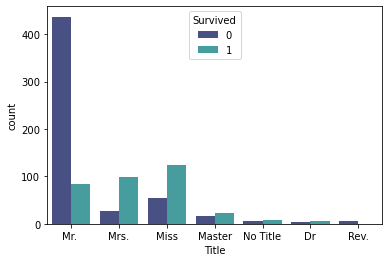

In [31]:
ax=sns.countplot(Train_full['Title'],hue='Survived',data=Train_full,palette='mako')

No particular pattern that is different from what is already observed in the survival across sexes chart

<a id='Corr'></a>
## Correlation matrix

In [32]:
Train_full.corr()['Survived']

Survived            1.000000
Pclass             -0.338481
Sex                 0.543351
Age                -0.064910
SibSp              -0.035322
Parch               0.081629
Fare                0.257307
Woman&UpperClass    0.412581
Embarked_C          0.168240
Embarked_Q          0.003650
Embarked_S         -0.149683
Fare_less50        -0.286113
Age Missing        -0.092197
IsChild             0.136107
Cabin Missing      -0.316912
A                   0.022287
B                   0.175095
C                   0.114652
D                   0.150716
E                   0.150716
F                   0.047930
G                   0.016040
IsAlone            -0.203367
FamilySize          0.016639
Fam_Size>=4        -0.125147
Mrs.                0.344223
Miss                0.327093
Master              0.085221
Dr                  0.037155
Rev.               -0.064988
Mr.                -0.543177
Name: Survived, dtype: float64

<a id='Drop'></a>
## Dropping variables that are no longer needed


In [33]:
Train_full.drop(['Cabin','Name','Title','Ticket','SibSp','Parch'],axis=1,inplace=True)
Test_full.drop(['Cabin','Name','Title','Ticket','SibSp','Parch'],axis=1,inplace=True)

In [34]:
Train_full.columns

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Woman&UpperClass',
       'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare_less50', 'Age Missing',
       'IsChild', 'Cabin Missing', 'A', 'B', 'C', 'D', 'E', 'F', 'G',
       'IsAlone', 'FamilySize', 'Fam_Size>=4', 'Mrs.', 'Miss', 'Master', 'Dr',
       'Rev.', 'Mr. '],
      dtype='object')

In [35]:
FeatureList=['Pclass', 'Name', 'Sex', 'Age',
       'Fare', 'Woman&UpperClass', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Age Missing', 'IsChild', 'Cabin Missing', 'A', 'B', 'C',
       'D', 'E', 'F', 'G', 'IsAlone', 'FamilySize', 'Fam_Size>=4', 'Title',
       'Mrs.', 'Miss', 'Master', 'Dr', 'Rev.', 'Mr. ']

In [36]:
Train_full.sample(3)

,Survived,Pclass,Sex,Age,Fare,Woman&UpperClass,Embarked_C,Embarked_Q,Embarked_S,Fare_less50,...,G,IsAlone,FamilySize,Fam_Size>=4,Mrs.,Miss,Master,Dr,Rev.,Mr.
PassengerId,,,,,,,,,,,,,,,,,,,,,
353,0,3,0,15.0,7.2292,0,1,0,0,1,...,False,0,2,0,False,False,False,False,False,True
788,0,3,0,8.0,29.1250,0,0,1,0,1,...,False,0,5,1,False,False,True,False,False,False
246,0,1,0,44.0,90.0000,0,0,1,0,0,...,False,0,2,0,False,False,False,True,False,False


<a id='Train'></a>
## Train-test split

In [37]:

#Separating target variable
Y=Train_full.Survived

#Separating features from target
X=Train_full.drop('Survived',axis=1)


#Separating training and testing data
from sklearn.model_selection import train_test_split
X_train, X_valid, Y_train, Y_valid=train_test_split(X,Y,train_size=0.7,test_size=0.3,stratify=Y,random_state=9)

<a id='Mod'></a>
# Modelling

## Metrics

In [38]:
#Function to measure accuracy and MAE of a model

from sklearn.metrics import mean_absolute_error, accuracy_score

from sklearn.model_selection import cross_val_score

<a id='RF'></a>
## Model 1: Random Forest

In [39]:
from sklearn.ensemble import RandomForestClassifier


model_1=RandomForestClassifier(random_state=13,n_estimators=1500,bootstrap=True,
                               max_depth=8,max_features='auto',min_samples_leaf=3)

#Print average cross validation score
print((cross_val_score(model_1,X=X,y=Y,scoring='accuracy',n_jobs=-1)).mean())

0.8305379448873266


<a id='RFGSCV'></a>
### Grid Search for hyperparameter tuning

In [40]:
from sklearn.model_selection import GridSearchCV

In [41]:
#  Using Grid Search to find the best parameters with Random Forest
model=RandomForestClassifier(random_state=1)

#Parameter range for the search grid
n_estimators=[2000]
max_features= ['auto']
max_depth=[5,7,9]
max_depth.append(None)
min_samples_split=[2,3,4]
min_samples_leaf = [1,2,3]
bootstrap = [True,False]
max_leaf_nodes=[4,6,8]


search_grid={'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
             'max_leaf_nodes':max_leaf_nodes}

#Instantiating Randomized Search CV
model_Grid= GridSearchCV(estimator = model,
                                param_grid= search_grid,  cv = 3, verbose=0,  n_jobs = -1)
model_Grid.fit(X,Y)

#Printing the best parameters found
print(model_Grid.best_params_)

{'bootstrap': True, 'max_depth': 7, 'max_features': 'auto', 'max_leaf_nodes': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 2000}


In [42]:
# Accuracy score of the model using best parameters
model_1=RandomForestClassifier(random_state=13)
model_1.set_params(**model_Grid.best_params_)
print((cross_val_score(model_1,X,Y)).mean())

0.8293892411022534


<a id='XGB'></a>
## Model 2: XGBoost

In [43]:

from xgboost import XGBClassifier

model_2=XGBClassifier(n_estimators=10000,learning_rate=0.3,min_child_weight=1,max_depth=6,subsample=1)

model_2.fit(X_train,Y_train,early_stopping_rounds=6,eval_set=[(X_valid,Y_valid)],verbose=0,eval_metric='error')

accuracy_score(y_pred=model_2.predict(X_valid),y_true=Y_valid)

0.8097014925373134

<a id='XGBGSCV'></a>
### Hyperparameter tuning

In [44]:
%%capture --no-stderr 
#Magic command to supress messages

from sklearn.model_selection import StratifiedKFold

model=XGBClassifier()
skf=StratifiedKFold(n_splits=3,shuffle=True,random_state=1)


# A list of parameter value ranges
n_estimators=[10000]
learning_rate=[x for x in np.linspace(start=0.03,stop=0.1,num=4)]
early_stopping_rounds=[4,8]
max_depth=[5,6,7,None]
min_child_weight=[1]
subsample=[0.9,1]
eval_metric=['error']

Grid={'n_estimators':n_estimators,'learning_rate':learning_rate,'early_stopping_rounds':early_stopping_rounds,
            'max_depth':max_depth,'min_child_weight': min_child_weight,'subsample':subsample,
               'eval_metric': eval_metric, 'verbose':[0]}

model_Grid=GridSearchCV(model,param_grid=Grid,cv=skf.split(X,Y),verbose=0,scoring='accuracy',n_jobs=-1)

model_Grid.fit(X,Y)

In [45]:
print(model_Grid.best_params_)
model_2=XGBClassifier()
model_2.set_params(**model_Grid.best_params_)
model_2.fit(X_train,Y_train)
accuracy_score(y_pred=model_2.predict(X_valid),y_true=Y_valid)

{'early_stopping_rounds': 4, 'eval_metric': 'error', 'learning_rate': 0.03, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 10000, 'subsample': 1, 'verbose': 0}
[23:07:45] WARNING: ..\src\learner.cc:541: 
Parameters: { early_stopping_rounds, verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




0.8022388059701493

Both Random Forest and XGB seem to have insignificant improvements with parameter tuning. Random Forest seems to be the better model in terms of accuracy

<a id='CF'></a>
## Plotting confusion matrix for both models

How many false positives and false negatives with each model?

Model  1 



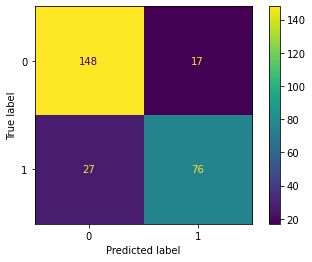


Model  2 



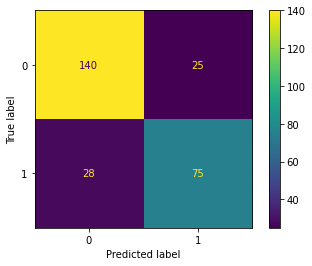

In [46]:
model_1.fit(X_train,Y_train)
Models=[model_1,model_2]
from sklearn.metrics import plot_confusion_matrix

for i,model in enumerate(Models):
    print("Model ",i+1,"\n")
    plot_confusion_matrix(model,X_valid,Y_valid)
    plt.show()
    print()

<a id='FI'></a>
## Feature importance for Random Forest
Which features were most useful in predicting? Although it is unnecessary to drop 'unimportant' features. Tree based methods always ensure that the features with the best classification ability (i.e. features that lead to 'leaves' with the least impurity) are always automatically selected

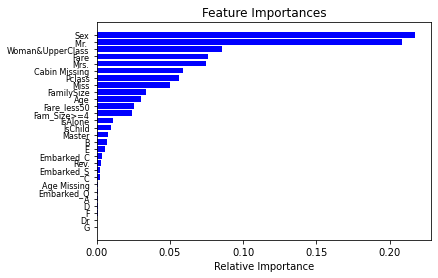

In [47]:
features=X.columns
importances=model_1.feature_importances_
indices=np.argsort(importances)
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices],fontsize=8)
plt.xlabel('Relative Importance')

plt.show()

As expected, Sex is the best feature for classification (this was earlier seen in the visualization as well)

<a id='Predict'></a>
# Predicting with final model, submission

In [48]:
model_1.fit(X,Y)

RandomForestClassifier(max_depth=7, max_leaf_nodes=8, n_estimators=2000,
                       random_state=13)

In [49]:
sub_preds = model_1.predict(Test_full)
output = pd.DataFrame({'PassengerId': Test_full.index,
                       'Survived': sub_preds})
output.to_csv('submission.csv',index=False)
output.head(5)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
